In [204]:
# we have to set env variable to use propack, if we want to use sparse2tuck
import os
os.environ["SCIPY_USE_PROPACK"] = "1"
import torch
import numpy as np
import tucker_riemopt
from tucker_riemopt import backend as back
from tucker_riemopt import set_backend
from tucker_riemopt.tucker.tucker import Tucker
from tucker_riemopt.sf_tucker.sf_tucker import SFTucker
import tucker_riemopt.sf_tucker.riemannian as riemann
from scipy.special import expit
from tqdm import tqdm
set_backend("pytorch")
from time import time
import random
from heapq import nlargest

# Example of Tucker Riemaniannian optimization

# Knowledge graphs

#### FB15-237 dataset

In [252]:
#Датасет качать отсюда ->  https://www.kaggle.com/datasets/huihuixu/fb15k-237
class Data:
    def __init__(self, data_dir="data/", reverse=False):
        self.train_data = self.load_data(data_dir, "train", reverse=reverse)
        self.valid_data = self.load_data(data_dir, "valid", reverse=reverse)
        self.test_data = self.load_data(data_dir, "test", reverse=reverse)
        self.data = self.train_data + self.valid_data + self.test_data
        self.entities = self.get_entities(self.data)
        self.train_relations = self.get_relations(self.train_data)
        self.valid_relations = self.get_relations(self.valid_data)
        self.test_relations = self.get_relations(self.test_data)
        self.relations = self.train_relations + [i for i in self.valid_relations \
                if i not in self.train_relations] + [i for i in self.test_relations \
                if i not in self.train_relations]
        self.entity_idxs = {self.entities[i]:i for i in range(len(self.entities))}
        self.relation_idxs = { self.relations[i]:i for i in range(len( self.relations))}
        
    def load_data(self, data_dir, data_type="train", reverse=False):
        with open("%s%s.txt" % (data_dir, data_type), "r") as f:
            data = f.read().strip().split("\n")
            data = [i.split() for i in data]
            if reverse:
                data += [[i[2], i[1]+"_reverse", i[0]] for i in data]
        return data

    def get_relations(self, data):
        relations = sorted(list(set([d[1] for d in data])))
        return relations

    def get_entities(self, data):
        entities = sorted(list(set([d[0] for d in data]+[d[2] for d in data])))
        return entities
    
    def get_data_idxs(self, data):
        data_idxs = [(self.entity_idxs[data[i][0]], self.relation_idxs[data[i][1]], \
                      self.entity_idxs[data[i][2]]) for i in range(len(data))]
        return data_idxs
    
    def get_tensor(self,data):
        idxs = self.get_data_idxs(data)
        N = len(self.entities)
        Rel = len(self.train_relations)
        Tensor = np.zeros([N,Rel,N], dtype =np.int8)
        for idx in idxs:
            Tensor[idx] = 1
        return Tensor

#usage example
N    = 5000#len(data.entities)   #bound on sampl and entities number
data = Data() #load data

dataset_idxs = data.get_data_idxs(data.train_data) #get train tensor indicies
dataset_idxs  = list(filter(lambda x: x[0] < N and x[2] < N, dataset_idxs))

test_idxs = data.get_data_idxs(data.test_data)
test_idxs = test_idxs  = list(filter(lambda x: x[0] < N and x[2] < N, test_idxs))

all_idxs = data.get_data_idxs(data.data)
all_idxs  = list(filter(lambda x: x[0] < N and x[2] < N, dataset_idxs))
# A = data.get_tensor(data.train_data) #get train tensor
# A[dataset_idxs[1245]] #check correct values

#### LOGLOSS FUCTIONAL (crossentropy)

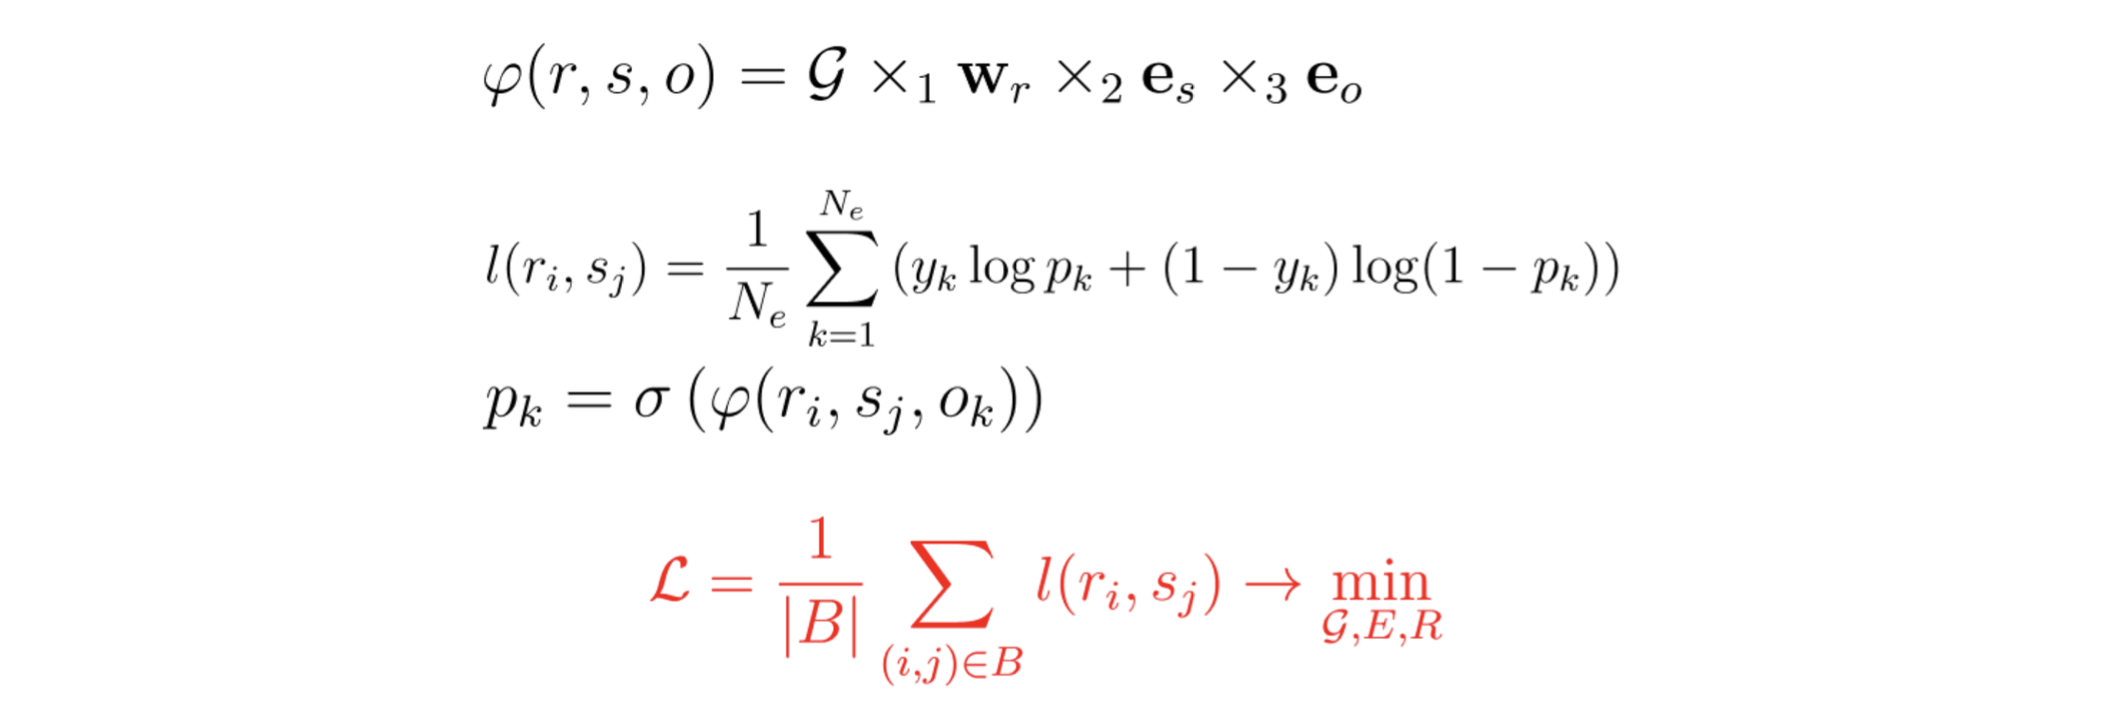

In [253]:
#for whole row along index k 
# def sigmoid(Tucker_tensor,i,j):
#     G = Tucker_tensor.core
# #     U,V,W = Tucker_tensor.factors
#     V = Tucker_tensor.factors[0]
#     U = Tucker_tensor.shared_factor
#     W = U
#     return 1/(1+torch.exp(-(back.einsum("jik,i,j,nk->n", G, U[i], V[j], W))))
def sigmoid(Tucker_tensor,i,j,k):
    G = Tucker_tensor.core
#     U,V,W = Tucker_tensor.factors
    V = Tucker_tensor.factors[0]
    U = Tucker_tensor.shared_factor
    W = U
    return 1/(1+torch.exp(-(back.einsum("jik,i,j,k->", G, U[i], V[j], W[k]))))


#local entropy along yk vector
def l(Tucker_tensor, i,j,k):
    res = 0.0
#     y = y.clone().detach()
    tolerance = 1e-7
#     K  = np.array(idxs)[(np.array(idxs)[:,0] == i) & (np.array(idxs)[:,1] == j)][:,2]
#     for k in K:
    p = sigmoid(Tucker_tensor, i, j,k)
    res = (torch.log(p + tolerance))
    return -1*res#-1/N*(y@torch.log(p + tolerance)) #+ (1 - y)@torch.log(1 - p + tolerance))

#returns vector y on train tensor corresponding index i, j along the dimension k
def get_y(idxs, i, j, Ne):
    res = torch.zeros(Ne,dtype= torch.float64)
    ones = list(filter(lambda x: x[0]==i and x[1]==j ,idxs))
    if ones !=[]:
        ones = np.array(ones)[:, 2]
        for pos in ones:
            res[pos] = 1
    return res

#Crossentropy
def L(Tucker_tensor):
    global bij
    global idxs
    global B
    I = bij #np.array(idxs)[:,0:2]
    res = 0.0
    for i, j,k in I:
        res += l(Tucker_tensor, i, j,k)
    return res / len(I) + 1e-12*Tucker_tensor.norm()**2

def get_batch(X_tucker, idxs):
    G = X_tucker.core
    U,V,W = X.factors
    U_cut = U[list(set(np.array(idxs)[:,0]))]
    V_cut = V[list(set(np.array(idxs)[:,1]))]
    return Tucker(G,[U_cut, V_cut,W])

def retraction(X, xi, r):
    return (X + xi).round(r)

def armijo(X, r, fx, xi,eta, alpha0):
    beta = 1 / 8
    c = 1e-4
    for m in range(10):
        alpha = alpha0 * (beta) ** m
        #print(fx - L(retraction(X,alpha*eta, r)), -c*xi.flat_inner(alpha*eta))
        if L(X) - L(retraction(X, alpha * eta, r)) >= -c * xi.flat_inner(alpha * eta):
            return alpha, m
    return alpha, m
        
def unique(idxs,B, i):
    batch = idxs[i*B:(i+1)*B]
    batch = list(set(batch))
    batch = np.array(batch)#[:,:2]
    return batch

#типа LL мы выводим а L - минимизируем
def LL(Tucker_tensor):
    global bij
    global idxs
    global B
    I = bij #np.array(idxs)[:,0:2]
    res = 0.0
    for i, j,k in I:
        res += l(Tucker_tensor, i, j, k)
    return res / len(I)

def get_elem_SFT(G, U, V, ijk:tuple):
    return torch.einsum("jik,i,j,k->",G,U[ijk[0]],V[ijk[1]],U[ijk[2]])

# def get_elem_SFT(G,U,V, ijk:list):
#     res = []
#     for i in tqdm(range(len(ijk))):
#         res.append(torch.einsum("jik,i,j,k->",G,U[ijk[i][0]],V[ijk[i][1]],U[ijk[i][2]]))
#     return res

#returns vector of probabilities of links betweem i and k
def ss(Tucker_tensor,i,k):
    G = Tucker_tensor.core
#     U,V,W = Tucker_tensor.factors
    V = Tucker_tensor.factors[0]
    U = Tucker_tensor.shared_factor
    W = U
    return 1/(1+torch.exp(-(back.einsum("jik,i,nj,k->n", G, U[i], V, W[k]))))

def hist1(X):
    global test_idxs
    sum_1 = 0
    sum_3 = 0
    sum_10 = 0
    rank = []
    for i, j, k in test_idxs:
        p = list(ss(X, i,k))
        val, ind  =torch.sort(torch.tensor(p), descending=True)
        for m in range(len(ind)):
            if ind[m]==j:
                rank.append(m+1)
                break
        p10 = nlargest(10, p)
        ind10 = [p.index(element) for element in p10]
        p3 =  nlargest(3,p10)
        ind3 = [p.index(element) for element in p3]
        p1 =  nlargest(1,p3)
        ind1 = [p.index(element) for element in p1]
#         p = 1 / (1 + torch.exp(-get_elem_SFT(X.core, X.shared_factor, X.factors[0], np.array([i, j, k]))))
        if (p1[0] > 0.5):
            if j in ind10:
                sum_10+=1
            if j in ind3:
                sum_3+=1
            if j in ind1:
                sum_1+=1
        MRR = np.mean(1/(np.array(rank)))
    return sum_1 / len(test_idxs), sum_3 / len(test_idxs), sum_10 / len(test_idxs), MRR

In [254]:
#initial condationps point

#random filling
re, rs = 50, 10
Ne = N
Nr = len(data.relations)
G = torch.rand((rs, re, re), dtype = torch.float64) * 0.1

U, _ = np.linalg.qr(np.random.randn(Ne, re))
V, _ = np.linalg.qr(np.random.randn(Nr, rs))
U = torch.tensor(U, dtype = torch.float64)
V = torch.tensor(V, dtype = torch.float64)

X = SFTucker(G, factors=[V], shared_factor=U)
hist1(X)

(0.0029965753424657533,
 0.011986301369863013,
 0.03724315068493151,
 0.023140387118472758)

In [ ]:
def riemmanian_CG(X, loss, r, B = 64, num_of_iter = 100):
    global bij
    metric = []
    Nr, Ne, _ = X.shape

    bij      = unique(idxs,B, 0)
    xi,fx    = riemann.grad(loss, X)
    xi       = xi.construct() 
#     xi       = xi / xi.norm()
    old_norm = xi.norm()
    eta      = -xi
    alpha    = 1e5/2
    X        = retraction(X, alpha * eta, r)
    print("number of batch ", Ne // B)
    for k in range(num_of_iter):
        print("epoch = ", k)
        start = time()
        for i in tqdm(range(Ne // B)):

            bij      = unique(idxs,B, i)
            xi,fx    = riemann.grad(loss, X)
            xi       = xi.construct()
#             xi       = xi / xi.norm()
            betta    = xi.norm() / old_norm
            old_norm = xi.norm()
            
            eta      = -xi + betta *riemann.project(X, eta).construct()
#             eta      /=eta.norm()
            alpha    = 1e5/2 #1e8
            alpha, m = armijo(X, r, fx, xi, eta, alpha)
            X        = retraction(X, alpha * eta, r)
            metric.append(hist1(X))
        random.shuffle(idxs)
        random.shuffle(idxs)
        #X.core = X.core * 0.5
        bij = unique(idxs, Ne, 0)
        epoch_loss = LL(X)#loss(X)
        print((X + xi).norm())
        hits1,hits3, hits10, MRR = hist1(X)
        print(f"alpha {alpha}   loss: {epoch_loss}   \nhits1: {hits1}   hits3: {hits3} hits10: {hits10}")
        print(f"MRR: {MRR}")
        if (epoch_loss < 8*1e-5):
            break
    return X, metric
B = 200
num_of_iter = 20
idxs = dataset_idxs

X, hist = riemmanian_CG(X, LL, [rs, re, re], B, num_of_iter)

number of batch  25
epoch =  0


100%|███████████████████████████████████████████| 25/25 [04:05<00:00,  9.82s/it]


tensor(6048.9323, dtype=torch.float64)
alpha 50000.0   loss: 0.6898732111645294   
hits1: 0.07148972602739725   hits3: 0.1035958904109589 hits10: 0.1579623287671233
MRR: 0.10545175137052523
epoch =  1


100%|███████████████████████████████████████████| 25/25 [04:08<00:00,  9.96s/it]


tensor(15555.3303, dtype=torch.float64)
alpha 50000.0   loss: 0.6652002843896593   
hits1: 0.09803082191780822   hits3: 0.13356164383561644 hits10: 0.1990582191780822
MRR: 0.13656946855267305
epoch =  2


100%|███████████████████████████████████████████| 25/25 [04:11<00:00, 10.06s/it]


tensor(24433.4335, dtype=torch.float64)
alpha 50000.0   loss: 0.6234700804293805   
hits1: 0.125   hits3: 0.16695205479452055 hits10: 0.2401541095890411
MRR: 0.16722167173604147
epoch =  3


100%|███████████████████████████████████████████| 25/25 [04:04<00:00,  9.76s/it]


tensor(34365.4712, dtype=torch.float64)
alpha 50000.0   loss: 0.5461222578213294   
hits1: 0.15496575342465754   hits3: 0.20633561643835616 hits10: 0.285958904109589
MRR: 0.2002645080076904
epoch =  4


100%|███████████████████████████████████████████| 25/25 [04:11<00:00, 10.05s/it]


tensor(43494.0562, dtype=torch.float64)
alpha 50000.0   loss: 0.4783818184736416   
hits1: 0.1815068493150685   hits3: 0.24529109589041095 hits10: 0.3300513698630137
MRR: 0.23460196929315094
epoch =  5


100%|███████████████████████████████████████████| 25/25 [03:58<00:00,  9.53s/it]


tensor(51064.3049, dtype=torch.float64)
alpha 50000.0   loss: 0.4473556193963397   
hits1: 0.2071917808219178   hits3: 0.2773972602739726 hits10: 0.3694349315068493
MRR: 0.2642140380287624
epoch =  6


100%|███████████████████████████████████████████| 25/25 [04:05<00:00,  9.81s/it]


tensor(58459.1738, dtype=torch.float64)
alpha 50000.0   loss: 0.40181707181048326   
hits1: 0.22902397260273974   hits3: 0.3047945205479452 hits10: 0.3985445205479452
MRR: 0.2895727115205699
epoch =  7


100%|███████████████████████████████████████████| 25/25 [04:09<00:00,  9.99s/it]


tensor(65229.5717, dtype=torch.float64)
alpha 50000.0   loss: 0.35191913421675314   
hits1: 0.2457191780821918   hits3: 0.3291952054794521 hits10: 0.4297945205479452
MRR: 0.31069137295403315
epoch =  8


100%|███████████████████████████████████████████| 25/25 [03:57<00:00,  9.49s/it]


tensor(71679.7135, dtype=torch.float64)
alpha 50000.0   loss: 0.3079458923931918   
hits1: 0.2628424657534247   hits3: 0.351027397260274 hits10: 0.4550513698630137
MRR: 0.3341366343328231
epoch =  9


100%|███████████████████████████████████████████| 25/25 [04:00<00:00,  9.63s/it]


tensor(76658.2613, dtype=torch.float64)
alpha 50000.0   loss: 0.2849698310841144   
hits1: 0.2778253424657534   hits3: 0.3728595890410959 hits10: 0.476027397260274
MRR: 0.3495337649059144
epoch =  10


100%|███████████████████████████████████████████| 25/25 [03:54<00:00,  9.40s/it]


tensor(82031.9011, dtype=torch.float64)
alpha 50000.0   loss: 0.2306882084921162   
hits1: 0.2936643835616438   hits3: 0.3874143835616438 hits10: 0.4965753424657534
MRR: 0.36364481520701314
epoch =  11


100%|███████████████████████████████████████████| 25/25 [03:50<00:00,  9.20s/it]


tensor(85409.0346, dtype=torch.float64)
alpha 50000.0   loss: 0.23842508841864082   
hits1: 0.3017979452054795   hits3: 0.4032534246575342 hits10: 0.5064212328767124
MRR: 0.37488706864930477
epoch =  12


100%|███████████████████████████████████████████| 25/25 [03:49<00:00,  9.18s/it]


tensor(89550.3653, dtype=torch.float64)
alpha 50000.0   loss: 0.21267253942268521   
hits1: 0.3116438356164384   hits3: 0.4208047945205479 hits10: 0.5201198630136986
MRR: 0.3873779262855513
epoch =  13


100%|███████████████████████████████████████████| 25/25 [04:02<00:00,  9.72s/it]


tensor(93710.8998, dtype=torch.float64)
alpha 50000.0   loss: 0.20523112567842258   
hits1: 0.3193493150684932   hits3: 0.4370719178082192 hits10: 0.533818493150685
MRR: 0.4003125815631655
epoch =  14


 60%|█████████████████████████▊                 | 15/25 [02:23<01:35,  9.56s/it]

In [ ]:
import matplotlib.pyplot as plt
ite = np.arange(0, num_of_iter, 1/(N//B)) 
fig,ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(ite, np.array(hist)[:,0], label = 'hits@1')
ax[0].plot(ite, np.array(hist)[:,1], label = 'hits@3')
ax[0].plot(ite, np.array(hist)[:,2], label = 'hits@10')
ax[0].set_title(f"Hits@1 re = {re} rs = {rs}")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("hits@")
ax[0].grid()
ax[0].legend()

ax[1].plot(ite, np.array(hist)[:,3], label = 'MRR')
ax[1].set_title(f"MRR re = {re} rs = {rs}")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("MRR")
ax[1].grid()
ax[1].legend()

## N = 2000

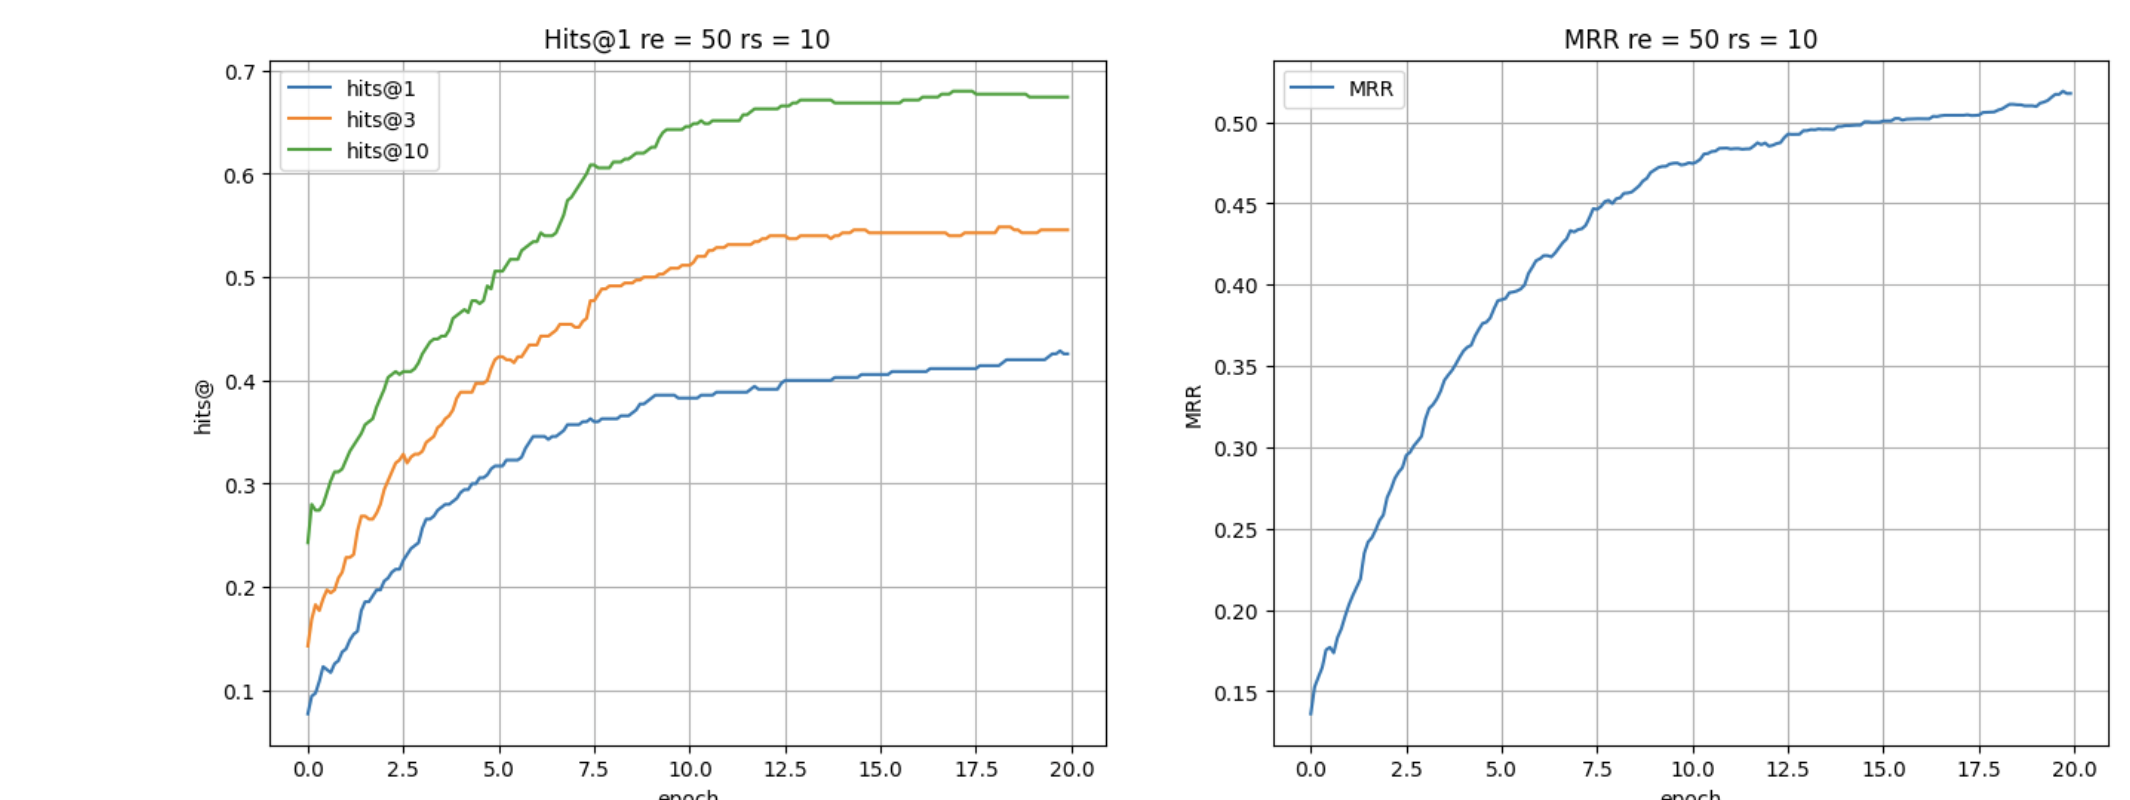

# Путник, не ходи этой дорогой, там тебя ждет лишь хаос

In [72]:
def ss(Tucker_tensor,i,k):
    G = Tucker_tensor.core
#     U,V,W = Tucker_tensor.factors
    V = Tucker_tensor.factors[0]
    U = Tucker_tensor.shared_factor
    W = U
    return 1/(1+torch.exp(-(back.einsum("jik,i,nj,k->n", G, U[i], V, W[k]))))
def predict_link(Tucker_tensor):
    links = []
    for i in tqdm(range(Tucker_tensor.shape[1])):
        for k in range(Tucker_tensor.shape[2]):
            p = ss(X, 0,0)
            maxp = max(p)
            if maxp>0.5:
                maxp_index = list(p).index(maxp)
                links.append((i,j,k))
    return links

In [ ]:
res = dict()
for i in range(X.shape[1]):
    for j in range(X.shape[0]):

###### Basic working tensors 
* $\text{Omega_dense} \approx I(0,1) $ is dense mask tensor 
* $\text{Omega_tucker}$ is Tucker representation of mask tensor
* $\text{X_dense} \approx R(0,1)$ is first target tensor approximation (dense tensor)
* $\text{X_tucker}$ is Tucker representation of first approximation

###### Examples of target tensors
* $\text{Sin_dense}(i_1,\ldots,i_d) = sin(i_1 + \ldots + i_d)$ is 2-rank target tensor 
* $\text{Sin_tucker}$ is Tucker representation of Sinus tensor
* $\text{Hilbert_dense}(i_1,\ldots,i_d) = \frac{1}{i_1 + \ldots + i_d + d}$ is target tensor with exponentially decaying singular numbers
* $\text{Hilbert_tucker}$ is Tucker representation of Hilbert tensor

In [ ]:
#init tensors and mask
size = 64

Sin_dense     = back.zeros([size,size,size])
# Hilbert_dense = back.zeros([size,size,size])
# Omega_dense   = back.zeros([size,size,size])
# X_dense       = back.zeros([size,size,size])

for i in range(size):
    for j in range(size):
        for k in range(size):
            Sin_dense[i][j][k]     = np.sin(i + j + k)
#             Hilbert_dense[i][j][k] = 1 / (i + j + k + 3)
#             Omega_dense[i][j][k]   = 1 if np.random.uniform() < 0.01 else 0
#             X_dense[i][j][k]       = np.random.uniform()

# Omega_tucker = Tucker.from_dense(Omega_dense)
Sin_tucker   = Tucker.from_dense(Sin_dense)
# X_tucker     = Tucker.from_dense(X_dense)

In [120]:
def Omega_projection(dense_tensor, Omega = Omega_dense):
    #Projection onto known tensor elements, given by dense Omega tensor
    #elementwise product
    return dense_tensor * Omega

def Tucker_Omega_projection(tucker_tensor, Omega = Omega_tucker):
    #Projection tensor given by tucker-format onto known tensor elements, given by dense Omega tensor
    #elementwise product in Tucker format
    return Tucker.from_dense(Omega_projection(tucker_tensor.to_dense()))

def Euclidean_grad(X, Target_tensor = Sin_tucker):
    return Tucker_Omega_projection(Target_tensor) - Tucker_Omega_projection(X)

def f(X, A = Sin_tucker):
    return 1/2 * (Tucker_Omega_projection(A) - Tucker_Omega_projection(X)).norm() ** 2

def line_search(eta, X):
    proj_eta = Tucker_Omega_projection(eta)
    return proj_eta.flat_inner(Euclidean_grad(X)) / (proj_eta.norm() ** 2)

def retraction(X, xi, r):
    return (X + xi).round([r, r, r])


In [4]:
xi,fx    = riemann.grad(f, X_tucker)
xi       = xi.construct()
eta      = -xi
alpha    = line_search(eta, X_tucker)
X_tucker = retraction(X_tucker, alpha * eta, 2)

In [5]:
max_iter = 150

for k in range(max_iter):
    betta = 1/(xi).norm()
    xi,fx = riemann.grad(f, X_tucker)
    xi = xi.construct()
    betta *=(xi).norm()
    eta   = -xi + betta*riemann.project(X_tucker, eta).construct()
    alpha = line_search(eta, X_tucker)
    X_tucker     = retraction(X_tucker, alpha*eta, 2)
    eps = back.sqrt(2*fx) / Sin_tucker.norm()
    
    if k % 50 == 0:
        print(round(float(eps),5))
    if eps < 1e-2:
        break

0.12124
0.08936
0.08711


In [6]:
print("Relative error: ||A-X||/||A|| ",round(float((Sin_dense - X_tucker.to_dense()).norm()/Sin_dense.norm()),5))

Relative error: ||A-X||/||A||  1.16606


## applied projection to each rank 

In [36]:
def get_triplet(core,v1,v2,v3, r1,r2,r3,Omega):
    return core[r1][r2][r3]*back.einsum("ijk,i,j,k->ijk",Omega, v1[:,r1],v2[:,r2],v3[:,r3])
def proj(tucker_tensor,R1,R2,R3, Omega=Omega_dense):
    res = back.zeros(tucker_tensor.shape)
    for r1 in range(R1):
        for r2 in range(R2):
            for r3 in range(R3):
                res += get_triplet(tucker_tensor.core,*tucker_tensor.factors, r1, r2, r3, Omega_dense)
    return Tucker.from_dense(res)

## Create list of sparse matrix

In [208]:
#Tried to use sparseTensor, but get bad results
three = []
size = 128
nnz = 300
Omega =back.zeros([size,size,size],dtype=int)
for i in range(nnz):
    three.append(tuple(np.random.randint(0, size,(3))))
    Omega[three[-1][0]][three[-1][1]][three[-1][2]]=1

In [209]:
def sp_pr(Sin_dense, three):    
    ZERO = back.zeros(Sin_dense.shape)
    vals = []
    for ind in three:
        ZERO[ind[0]][ind[1]][ind[2]] = Sin_dense[ind[0]][ind[1]][ind[2]]
        vals.append(Sin_dense[ind[0]][ind[1]][ind[2]])
    return ZERO, vals

In [270]:
def q(three,sparse_dense):
#     sparse_tensor = tucker_riemopt.SparseTensor([128,128,128],np.array(three).T,vals)
    sparse_tensor = tucker_riemopt.SparseTensor.dense2sparse(sparse_dense)
    r=Tucker.sparse2tuck(sparse_tensor,[128,128,128])
    return r

In [271]:
sparse_dense, vals=sp_pr(Sin_dense, three)

In [272]:
%time tensor = q(three,sparse_dense)

CPU times: user 1min 7s, sys: 10.7 s, total: 1min 18s
Wall time: 19.3 s


In [164]:
#made just for fun
def hadamard_product(t1,t2):
    core = back.kron(t1.core, t2.core)
    factor0 = back.khatri_rao([t1.factors[0], t2.factors[0]]).T
    factor1 = back.khatri_rao([t1.factors[1], t2.factors[1]]).T
    factor2 = back.khatri_rao([t1.factors[2], t2.factors[2]]).T
    return Tucker(core, [factor0,factor1,factor2])